# MNIST Exploration

![MNIST](./../../imgs/MNIST.jpg)

This notebook is an exploration for the dataset MNIST (Modified National Institute of Standards and Technology). MNIST is a large database of handwritten digits that is commonly used for training various image processing systems.

1. [Introduction](#1-introduction)  
    1.1 [Objective of the Analysis](#11-objective-of-the-analysis)
    1.2 [Overview of the MNIST Dataset](#12-overview-of-the-mnist-dataset)  
    1.3 [Relevance to the Research and Deep Learning Library](#13-relevance-to-the-research-and-deep-learning-library)

2. [Loading and Preprocessing the Data](#2-loading-and-preprocessing-the-data)  
    2.1 [Loading MNIST Dataset Using External Library](#21-loading-mnist-dataset-using-external-library)  
    2.2 [Data Structure and Format Overview](#22-data-structure-and-format-overview)

3. [Statistical Overview](#3-statistical-overview)  
    3.1 [Class Distribution (Digit Frequency)](#31-class-distribution-digit-frequency)  
    3.2 [Basic Statistical Measures (Mean, Variance, etc.)](#32-basic-statistical-measures-mean-variance-etc)  
    3.3 [Identifying Imbalance in Data](#33-identifying-imbalance-in-data)

4. [Data Visualization](#4-data-visualization)  
    4.1 [Sample Visualizations of MNIST Digits](#41-sample-visualizations-of-mnist-digits)  
    4.2 [Heatmaps of Sample Images](#42-heatmaps-of-sample-images)

5. [Data Preparation for Modeling](#5-data-preparation-for-modeling)  
    5.1 [Train-Test Split](#51-train-test-split)  
    5.2 [Preparing Data for Neural Network Input](#52-preparing-data-for-neural-network-input)

6. [MLP Digit Recognition](#6-mlp-digit-recognition)  
    6.1 [Building a Simple MLP Model](#61-building-a-simple-mlp-model)  
    6.2 [Training the MLP on MNIST](#62-training-the-mlp-on-mnist)  
    6.3 [Evaluating Model Performance (Accuracy, Loss)](#63-evaluating-model-performance-accuracy-loss)  
    6.4 [Visualizing Model Predictions](#64-visualizing-model-predictions)


## 1. Introduction

In the ever-evolving field of deep learning, the ability to accurately recognize handwritten digits is a foundational task that showcases the potential of neural networks. The MNIST dataset, comprising 70,000 images of handwritten digits ranging from 0 to 9, serves as a benchmark for evaluating various machine learning models.

In the ever-evolving field of deep learning, the ability to accurately recognize handwritten digits is a foundational task that showcases the potential of neural networks. The MNIST dataset, comprising 70,000 images of handwritten digits ranging from 0 to 9, serves as a benchmark for evaluating various machine learning models.

### 1.1 Objective of the analysis

The primary objective of this analysis is to conduct a comprehensive exploration of the MNIST dataset. By understanding its structure and characteristics, we aim to establish a robust foundation for the practical implementation of a Multi-Layer Perceptron (MLP) model within our deep learning library.

### 1.2 Overview of the MNIST Dataset

The MNIST dataset is divided into a training set of 60,000 images and a test set of 10,000 images. Each image is a grayscale representation of a handwritten digit, with a resolution of 28x28 pixels. This uniformity and scale make it an ideal dataset for experimenting with various deep learning architectures.

The MNIST dataset is divided into a training set of 60,000 images and a test set of 10,000 images. Each image is a grayscale representation of a handwritten digit, with a resolution of 28x28 pixels. This uniformity and scale make it an ideal dataset for experimenting with various deep learning architectures.

### 1.3 Relevance to the Research and Deep Learning Library

The insights gained from this exploratory analysis will not only contribute to the academic rigor of our research work but also enhance the usability and performance of our deep learning library. By providing a thorough examination of the dataset, we can ensure that our library is equipped to handle similar tasks effectively, paving the way for future advancements in digit recognition and beyond.

## 2. Loading and Preprocessing the Data

### 2.1 Loading MNIST Dataset Using External Library

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., torchvision.datasets.MNIST in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

We will load the MNIST dataset using the code authored by Marc Garcia, which can be found [here](https://github.com/datapythonista/mnist). This code efficiently retrieves the dataset in a structured format, facilitating further analysis. We will ensure to include the proper attribution to the original source.

In [27]:
# All attrs. to Marc Garcia (https://github.com/datapythonista/mnist)

import os
import functools
import operator
import gzip
import struct
import array
import tempfile
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve  # py2
try:
    from urllib.parse import urljoin
except ImportError:
    from urlparse import urljoin
import numpy


# `datasets_url` and `temporary_dir` can be set by the user using:
# >>> mnist.datasets_url = 'http://my.mnist.url'
# >>> mnist.temporary_dir = lambda: '/tmp/mnist'
datasets_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
temporary_dir = tempfile.gettempdir


class IdxDecodeError(ValueError):
    """Raised when an invalid idx file is parsed."""
    pass


def download_file(fname, target_dir=None, force=False):
    """Download fname from the datasets_url, and save it to target_dir,
    unless the file already exists, and force is False.

    Parameters
    ----------
    fname : str
        Name of the file to download

    target_dir : str
        Directory where to store the file

    force : bool
        Force downloading the file, if it already exists

    Returns
    -------
    fname : str
        Full path of the downloaded file
    """
    target_dir = target_dir or temporary_dir()
    target_fname = os.path.join(target_dir, fname)

    if force or not os.path.isfile(target_fname):
        url = urljoin(datasets_url, fname)
        urlretrieve(url, target_fname)

    return target_fname


def parse_idx(fd):
    """Parse an IDX file, and return it as a numpy array.

    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse

    endian : str
        Byte order of the IDX file. See [1] for available options

    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file

    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))

    return numpy.array(data).reshape(dimension_sizes)


def download_and_parse_mnist_file(fname, target_dir=None, force=False):
    """Download the IDX file named fname from the URL specified in dataset_url
    and return it as a numpy array.

    Parameters
    ----------
    fname : str
        File name to download and parse

    target_dir : str
        Directory where to store the file

    force : bool
        Force downloading the file, if it already exists

    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file
    """
    fname = download_file(fname, target_dir=target_dir, force=force)
    fopen = gzip.open if os.path.splitext(fname)[1] == '.gz' else open
    with fopen(fname, 'rb') as fd:
        return parse_idx(fd)


def train_images():
    """Return train images from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    train_images : numpy.ndarray
        Numpy array with the images in the train MNIST database. The first
        dimension indexes each sample, while the other two index rows and
        columns of the image
    """
    return download_and_parse_mnist_file('train-images-idx3-ubyte.gz')


def test_images():
    """Return test images from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    test_images : numpy.ndarray
        Numpy array with the images in the train MNIST database. The first
        dimension indexes each sample, while the other two index rows and
        columns of the image
    """
    return download_and_parse_mnist_file('t10k-images-idx3-ubyte.gz')


def train_labels():
    """Return train labels from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    train_labels : numpy.ndarray
        Numpy array with the labels 0 to 9 in the train MNIST database.
    """
    return download_and_parse_mnist_file('train-labels-idx1-ubyte.gz')


def test_labels():
    """Return test labels from Yann LeCun MNIST database as a numpy array.
    Download the file, if not already found in the temporary directory of
    the system.

    Returns
    -------
    test_labels : numpy.ndarray
        Numpy array with the labels 0 to 9 in the train MNIST database.
    """
    return download_and_parse_mnist_file('t10k-labels-idx1-ubyte.gz')


The provided code snippet is designed to download and parse the MNIST dataset, a widely used collection of handwritten digits for training and testing image processing systems. The main functionalities included are:

- Downloading Files: The download_file function retrieves the required files from a specified URL and saves them in a designated directory, ensuring that files are only downloaded if they do not already exist (unless forced).

- Parsing IDX Format: The parse_idx function reads IDX files, which are used for storing image and label data in the MNIST dataset. It unpacks the binary data and converts it into NumPy arrays, facilitating easy manipulation and analysis.

- Data Retrieval Functions: Specific functions, such as train_images(), test_images(), train_labels(), and test_labels(), are defined to load the training and testing images and labels as NumPy arrays. Each function calls the download_and_parse_mnist_file, ensuring that the data is fetched and correctly formatted.

Overall, this code efficiently sets up the foundation for working with the MNIST dataset, allowing for seamless integration into deep learning models.

### 2.2 Data Structure and Format Overview

Once the dataset is loaded, it is important to understand how the data is structured and returned. The `download_and_parse_mnist_file` function retrieves the dataset as NumPy arrays, making it suitable for further analysis and modeling.

- Images: The training and test images are returned as NumPy arrays.

- Labels: The training and test labels are returned as NumPy arrays.

By leveraging these NumPy arrays, we can perform efficient computations and manipulations essential for deep learning tasks.

Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)


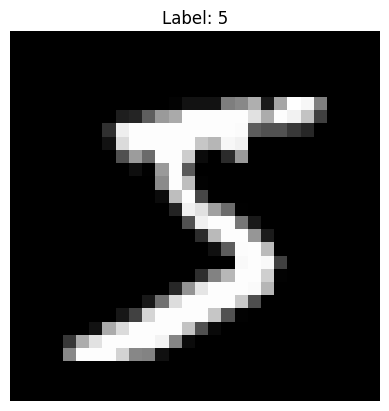

In [1]:
# Load the MNIST dataset
import mnist
import numpy as np

# Load training images and labels
train_images = mnist.train_images()
train_labels = mnist.train_labels()

# Check the shape of the training images
print("Training Images Shape:", train_images.shape)  # Output: (60000, 28, 28)

# Check the shape of the training labels
print("Training Labels Shape:", train_labels.shape)  # Output: (60000,)

# Display the first image and its corresponding label
import matplotlib.pyplot as plt

plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.show()

The data for the images and labels is organized in a structured manner to facilitate efficient processing. The training images are represented as a 3D NumPy array with the shape `(60000, 28, 28)`, where each image is a 28x28 pixel grid, and the first dimension corresponds to the number of images. In contrast, the training labels are stored as a 1D NumPy array with the shape `(60000,)`, where each entry corresponds to the label of the respective image. This arrangement allows for seamless integration when feeding the data into neural networks, as both images and labels can be easily indexed and manipulated.



## 3. Statistical Overview

### 3.1 Class Distribution (Digit Frequency)

Understanding the distribution of classes within the MNIST dataset is crucial for identifying potential biases and ensuring a balanced representation of the digits from 0 to 9. In this section, we will analyze the frequency of each digit in the training labels.

To begin, we will utilize NumPy to count the occurrences of each digit in the training labels. This information can provide insights into the dataset's balance and inform any necessary adjustments during preprocessing or model training.

In [2]:
# Count the frequency of each digit in the training labels
digit_counts = np.bincount(train_labels)

# Display the frequency of each digit
for digit, count in enumerate(digit_counts):
    print(f"Digit {digit}: {count} occurrences")

Digit 0: 5923 occurrences
Digit 1: 6742 occurrences
Digit 2: 5958 occurrences
Digit 3: 6131 occurrences
Digit 4: 5842 occurrences
Digit 5: 5421 occurrences
Digit 6: 5918 occurrences
Digit 7: 6265 occurrences
Digit 8: 5851 occurrences
Digit 9: 5949 occurrences


The output will reveal the number of occurrences for each digit, allowing us to visually assess the distribution.

We can also visualize this distribution using a bar chart for a more intuitive understanding:

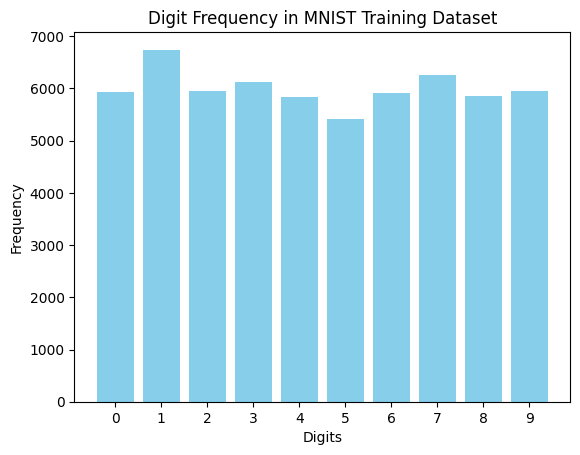

In [3]:
# Visualizing the digit frequency
import matplotlib.pyplot as plt

plt.bar(range(10), digit_counts, color='skyblue')
plt.xticks(range(10))
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Digit Frequency in MNIST Training Dataset')
plt.show()

This bar chart clearly illustrates the frequency of each digit, helping to identify whether the dataset is balanced or if certain digits are underrepresented. A balanced dataset is essential for training robust machine learning models, as it helps mitigate the risk of bias towards more frequently occurring classes.

### 3.2 Basic Statistical Measures (Mean, Variance, etc.)

In this section, we will explore basic statistical measures of the MNIST dataset to gain insights into the characteristics of the pixel values across the images. Specifically, we will calculate the mean and variance of the pixel intensities, which can provide valuable information about the dataset's overall distribution.

The pixel values in MNIST images range from 0 to 255, representing grayscale intensity. A thorough understanding of these measures can help in preprocessing steps, such as normalization.

Calculating Mean and Variance
We will compute the mean and variance for the training images using NumPy.In this section, we will explore basic statistical measures of the MNIST dataset to gain insights into the characteristics of the pixel values across the images. Specifically, we will calculate the mean and variance of the pixel intensities, which can provide valuable information about the dataset's overall distribution.

The pixel values in MNIST images range from 0 to 255, representing grayscale intensity. A thorough understanding of these measures can help in preprocessing steps, such as normalization.

**Calculating Mean and Variance** \
We will compute the mean and variance for the training images using NumPy.

In [4]:
# Calculate the mean and variance of the training images
mean_pixel_value = np.mean(train_images)
variance_pixel_value = np.var(train_images)

print(f"Mean Pixel Value: {mean_pixel_value}")
print(f"Variance of Pixel Values: {variance_pixel_value}")

Mean Pixel Value: 33.318421449829934
Variance of Pixel Values: 6172.850482291342


The mean pixel value indicates the average intensity of the images, while the variance measures how spread out the pixel values are from the mean. A low variance suggests that the pixel values are closely clustered around the mean, whereas a high variance indicates a wider spread of values.

**Visualizing Pixel Value Distribution** \
To visualize the distribution of pixel values, we can create a histogram. This will provide a clearer view of how pixel intensities are distributed across the training images.

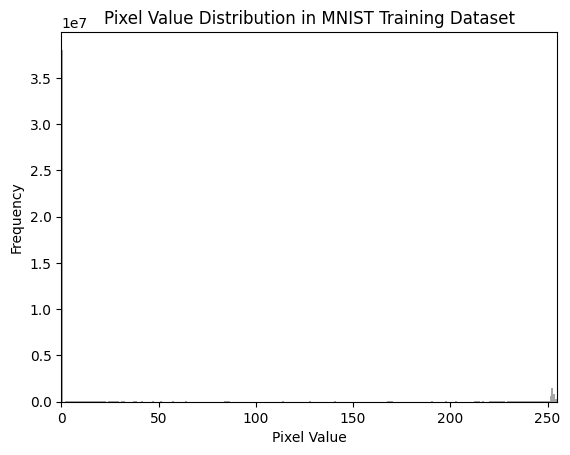

In [5]:
# Visualizing the distribution of pixel values
plt.hist(train_images.flatten(), bins=256, color='gray', alpha=0.7)
plt.title('Pixel Value Distribution in MNIST Training Dataset')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.xlim([0, 255])
plt.show()

The histogram illustrates how frequently each pixel value appears in the dataset, offering insights into the overall brightness and contrast of the images.

Understanding these basic statistical measures is vital for further analysis and model development, particularly in determining the need for data normalization or augmentation.

## 4. Data Visualization

### 4.1 Sample Visualizations of MNIST Digits

Visualizing the dataset is an essential step in understanding the characteristics of the MNIST digits. By examining a few samples, we can gain insights into the diversity of handwriting styles present in the dataset.

**Displaying Sample Images** \
We will randomly select and display a few images from the training set along with their corresponding labels. This will illustrate the variety of digits and the quality of the images.

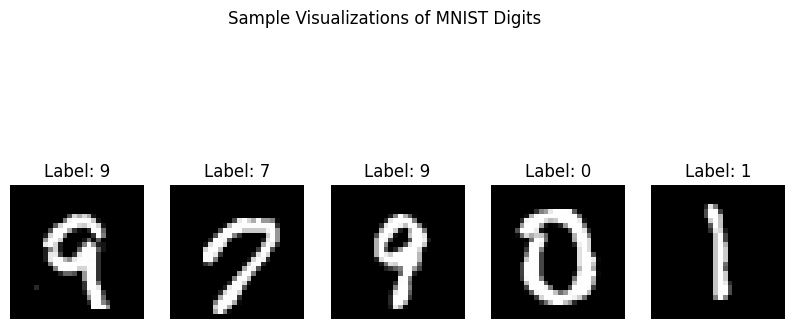

In [6]:
import random

# Number of samples to display
num_samples = 5
random_indices = random.sample(range(len(train_images)), num_samples)

# Create a figure for the samples
plt.figure(figsize=(10, 5))

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.title(f"Label: {train_labels[idx]}")
    plt.axis('off')

plt.suptitle('Sample Visualizations of MNIST Digits')
plt.show()

**Insights from Visualization** \
By visualizing these samples, we can observe:

- The diversity in handwriting styles for each digit.
- The quality and resolution of the images, which are consistent across the dataset.
- Any potential variations or patterns that may be useful in the classification task.

This exploration sets the stage for deeper analysis and modeling, as we will see how these visual characteristics impact the performance of our machine learning algorithms.

### 4.2 Heatmaps of Sample Images

Heatmaps provide a visual representation of pixel intensity values, showcasing how the brightness of pixels varies across different digits in the MNIST dataset. Each pixel's value is represented with a color gradient, enabling us to identify patterns and structures within the digits.

**Visualizing Sample Images as Heatmaps** \
We will generate heatmaps for selected sample images, where the intensity of each pixel is represented by color.

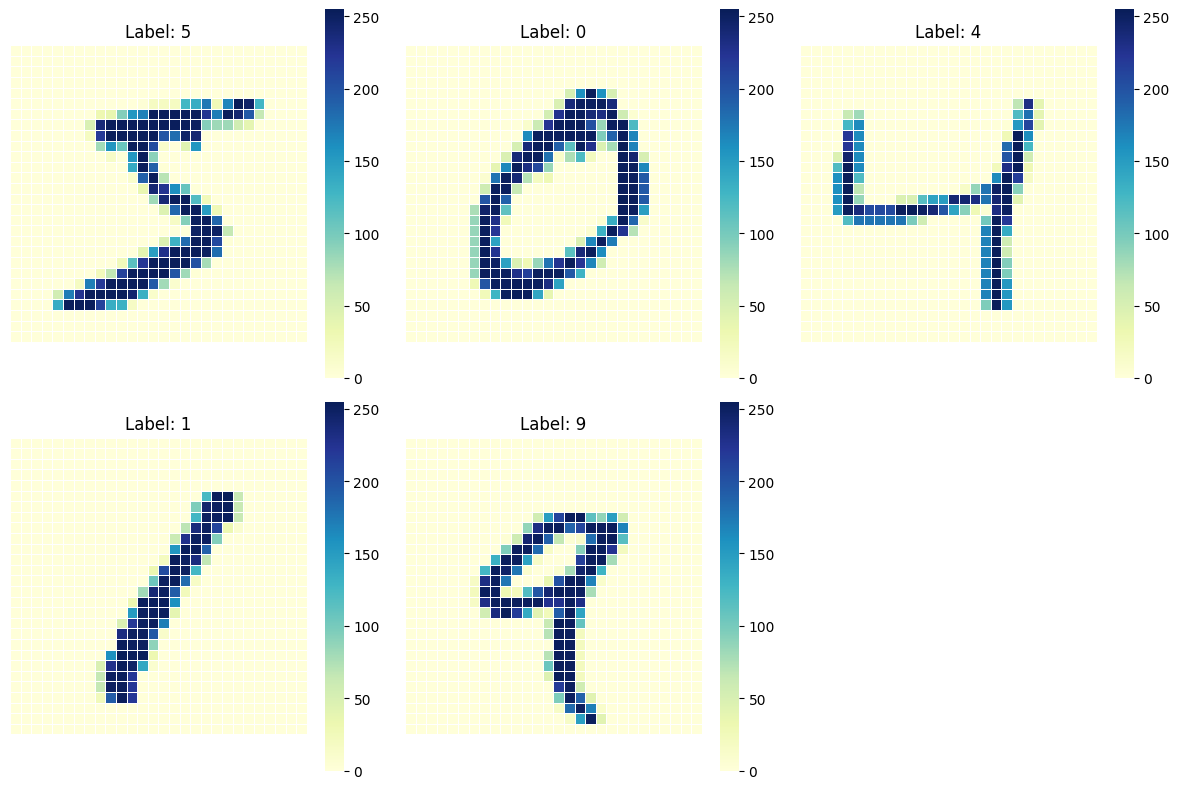

In [7]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few sample images and their corresponding labels
sample_indices = [0, 1, 2, 3, 4]
sample_images = train_images[sample_indices]
sample_labels = train_labels[sample_indices]

# Set up the heatmap visualization
plt.figure(figsize=(12, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(sample_images[i], cmap='YlGnBu', cbar=True, square=True, annot=False, linewidths=0.5)
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Insights from the Heatmaps

- Color Gradient: The colors indicate the pixel intensity values, where darker areas represent lower intensity (more black), and lighter areas represent higher intensity (more white).

- Structural Patterns: These heatmaps help in visualizing the structure of each digit, revealing important features that are essential for classification.

- Data Analysis: By analyzing these heatmaps, we can identify regions of high intensity that contribute significantly to the recognition of the digit.

This representation enhances our understanding of how digit shapes are formed from pixel intensity distributions.

## 5. Data Preparation for Modeling

### 5.1 Train-Test Split

A crucial step in preparing our dataset for training machine learning models is to split the data into distinct training and testing sets. This ensures that our model is evaluated on unseen data, allowing us to gauge its performance accurately.

**Creating the Train-Test Split** \
In the context of the MNIST dataset, we will use the training set for training the model and the test set for evaluation. The MNIST dataset already provides separate training and test images and labels, with the training set containing 60,000 samples and the test set containing 10,000 samples.

In [8]:
# Load training and test images and labels
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Verify the shapes of the datasets
print("Train Images Shape:", train_images.shape)  # Output: (60000, 28, 28)
print("Train Labels Shape:", train_labels.shape)  # Output: (60000,)
print("Test Images Shape:", test_images.shape)    # Output: (10000, 28, 28)
print("Test Labels Shape:", test_labels.shape)    # Output: (10000,)

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


### 5.2 Preparing Data for Neural Network Input

Once we have successfully split our dataset into training and testing sets, the next step involves preparing the data for input into our neural network. This preparation is crucial to ensure that the data is in the correct format and scale for optimal model performance.

**Steps for Data Preparation** \

1. Reshaping the Data: Neural networks typically expect input data in a flat structure. For the MNIST dataset, each image is a 28x28 matrix of pixel values. We need to flatten these images into 1D arrays.

2. Normalizing Pixel Values: The pixel values in the MNIST dataset range from 0 to 255. For many neural network models, especially those using activation functions like sigmoid or softmax, it is beneficial to normalize these values to a range between 0 and 1.

3. Converting Labels to Categorical: If using a model that requires categorical output (like softmax), we will convert our labels into a one-hot encoded format.

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Reshape the images to be 1D arrays
train_images_reshaped = train_images.reshape(train_images.shape[0], -1)
test_images_reshaped = test_images.reshape(test_images.shape[0], -1)

# Normalize the pixel values to the range [0, 1]
train_images_normalized = train_images_reshaped / 255.0
test_images_normalized = test_images_reshaped / 255.0

# Convert labels to one-hot encoding
encoder = OneHotEncoder()
train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_labels.reshape(-1, 1))

# Check the shapes of the prepared datasets
print("Prepared Train Images Shape:", train_images_normalized.shape)  # Output: (60000, 784)
print("Prepared Train Labels Shape:", train_labels_one_hot.shape)     # Output: (60000, 10)
print("Prepared Test Images Shape:", test_images_normalized.shape)    # Output: (10000, 784)
print("Prepared Test Labels Shape:", test_labels_one_hot.shape)       # Output: (10000, 10)

Prepared Train Images Shape: (60000, 784)
Prepared Train Labels Shape: (60000, 10)
Prepared Test Images Shape: (10000, 784)
Prepared Test Labels Shape: (10000, 10)


Summary of the Preparation

- Reshaping: The 28x28 images are flattened into 784-dimensional vectors.
- Normalization: Pixel values are scaled down to a range of [0, 1] for improved training stability and performance.
- One-Hot Encoding: Labels are transformed into a binary matrix suitable for classification tasks.

By following these steps, our data is now appropriately formatted and ready for training our neural network model.

## 6. MLP Digit Recognition

### 6.1 Building a Simple MLP Model

### 6.2 Training the MLP on MNIST

### 6.3 Evaluating Model Performance (Accuracy, Loss)

### 6.4 Visualizing Model Predictions

In [10]:
import mnist
import numpy as np
import pandas as pd
from matplotlib import pyplot

In [11]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

df_imgs  = pd.DataFrame(train_images[0])
df_labls = pd.DataFrame(train_labels[:1000])